  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 6745, number of used features: 22
[LightGBM] [Info] Start training from score 1.466271
Prediction saved to G:\ganga abc\Output\Dosa prediction vs actuals.xlsx
Test RMSE: 1.3543646822147992
Model Accuracy: 54.92%
Final output saved to final_output_dosa.xlsx


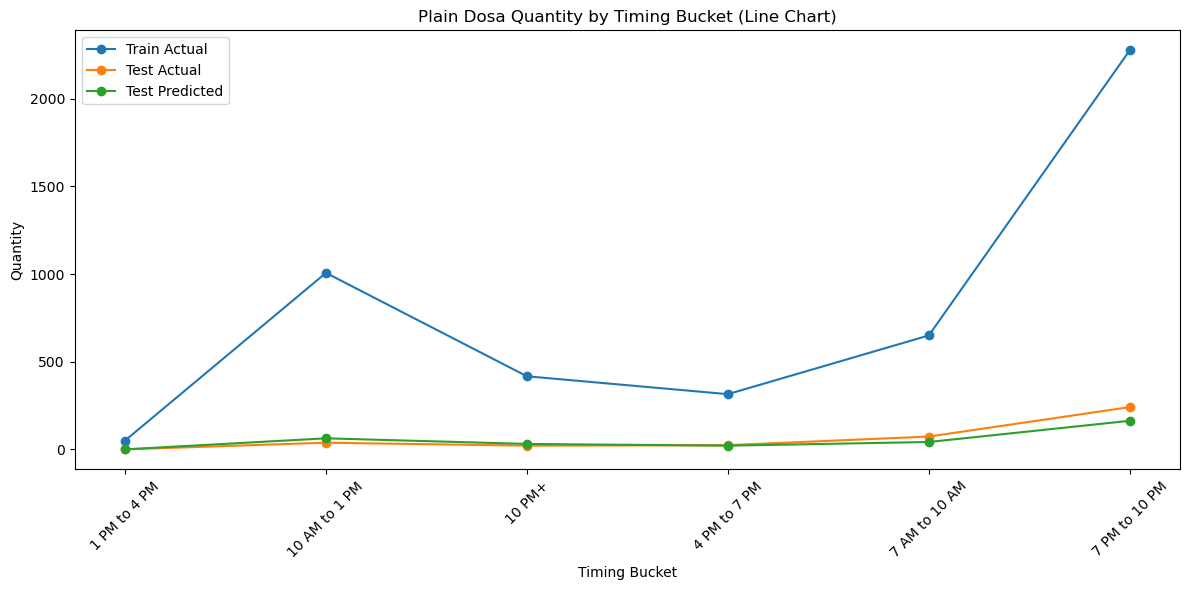

In [16]:
import pandas as pd
!pip install lightgbm

# File paths (change these to your actual file paths)
file1 = r"G:\ganga abc\Input\Pudur Feb 2025.xlsx"
file2 = r"G:\ganga abc\Input\Pudur March 2025.xlsx"
file3 = r"G:\ganga abc\Input\Pudur April 2025.xlsx"

# Read all three files
df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)
df3 = pd.read_excel(file3)

combined_df = pd.concat([df1, df2, df3], ignore_index=True)

mdf = pd.read_excel(r"G:\ganga abc\Input\Tamil_Calendar_with_Muhurtham_2025_updated.xlsx")
combined_df['created_on'] = pd.to_datetime(combined_df['created_on'], dayfirst=True, errors='coerce').dt.date
mdf['Start Date'] = pd.to_datetime(mdf['Start Date'], dayfirst=True, errors='coerce').dt.date
combined_df = combined_df.merge(
    mdf[['Start Date', 'Muhurtham Day']],
    left_on='created_on',
    right_on='Start Date',
    how='left'
).drop(columns=['Start Date'])
combined_df['created_on'] = pd.to_datetime(combined_df['created_on']).dt.strftime('%d-%m-%Y')
combined_df = combined_df[combined_df['category_name'].isin(['Dosa & Uthappam'])]
combined_df.head(10)
combined_df = combined_df[~combined_df['product_name'].str.contains('Rava', case=False, na=False)]
combined_df['product_date'] = combined_df['product_date'].str.replace(' AM', '', regex=False)
combined_df['product_date'] = combined_df['product_date'].str.replace(' PM', '', regex=False)
import pandas as pd

# Convert product_date to datetime
combined_df['product_date'] = pd.to_datetime(combined_df['product_date'], format='%d-%m-%Y %H:%M:%S')

# Extract hour (24-hour format)
combined_df['hour'] = combined_df['product_date'].dt.hour

# Define function to bucket time
def time_bucket(hour):
    if 7 <= hour < 10:
        return '7 AM to 10 AM'
    elif 10 <= hour < 13:
        return '10 AM to 1 PM'
    elif 13 <= hour < 16:
        return '1 PM to 4 PM'
    elif 16 <= hour < 19:
        return '4 PM to 7 PM'
    elif 19 <= hour < 22:
        return '7 PM to 10 PM'
    else:
        return '10 PM+'

# Apply function to hour column
combined_df['timing_bucket'] = combined_df['hour'].apply(time_bucket)

# Optional: drop the helper 'hour' column
combined_df.drop(columns=['hour'], inplace=True)
df = combined_df.copy()
df.rename(columns={"created_on": "Date"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.columns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
# 2. Preprocessing
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
df['Muhurtham Day'] = df['Muhurtham Day'].map({'yes': 1, 'no': 0})
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month

# One-hot encode timing_bucket and product_name
df = pd.get_dummies(df, columns=['timing_bucket', 'product_name'])

# Define feature columns
timing_buckets = [col for col in df.columns if col.startswith('timing_bucket_')]
product_names = [col for col in df.columns if col.startswith('product_name_')]
features = ['Muhurtham Day', 'day_of_week', 'month'] + timing_buckets + product_names
target = 'quantity'

# 3. Train/Test Split
last_date = df['Date'].max()
cutoff_date = last_date - pd.Timedelta(days=7)
df_train = df[df['Date'] <= cutoff_date]
df_test = df[df['Date'] > cutoff_date]

X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

# 4. Train Model
model = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# 5. Predict on last 7 days and round
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)

# 6. Prepare output DataFrame (Predicted vs Actuals)
X_test_copy = X_test.copy()
X_test_copy['Date'] = df_test['Date'].values
X_test_copy['Actual_Quantity'] = y_test.values
X_test_copy['Predicted_Quantity'] = y_pred_rounded

# Extract readable timing bucket and product name
X_test_copy['timing_bucket'] = X_test_copy[timing_buckets].idxmax(axis=1).str.replace('timing_bucket_', '')
X_test_copy['product_name'] = X_test_copy[product_names].idxmax(axis=1).str.replace('product_name_', '')

# 7. Group by Date, product_name, timing_bucket and aggregate
final_output = X_test_copy.groupby(
    ['Date', 'product_name', 'timing_bucket'], as_index=False
).agg({
    'Actual_Quantity': 'sum',
    'Predicted_Quantity': 'sum'
})
final_output['Predicted_Quantity'] = final_output['Predicted_Quantity'].round().astype(int)
final_output['Difference'] = final_output['Actual_Quantity'] - final_output['Predicted_Quantity']

# 8. Save to Excel
output_path = r"G:\ganga abc\Output\Dosa prediction vs actuals.xlsx"
final_output.to_excel(output_path, index=False)
print(f"Prediction saved to {output_path}")

# 9. Print accuracy for these 7 days
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
accuracy = r2_score(y_test, y_pred) * 100
print("Test RMSE:", rmse)
print(f"Model Accuracy: {accuracy:.2f}%")
# Replace all values in 'product_name' with 'Dosa'
final_output['product_name'] = 'Dosa'

# Group by 'Date' and 'timing_bucket', summing the quantities
result = (
    final_output.groupby(['Date', 'timing_bucket', 'product_name'], as_index=False)[['Actual_Quantity', 'Predicted_Quantity']].sum()
)

# Calculate the difference
result['Difference'] = result['Actual_Quantity'] - result['Predicted_Quantity']

result.to_excel(r"G:\ganga abc\Output\Overall Dosa prediction.xlsx", index=False)
print("Final output saved to final_output_dosa.xlsx")

import matplotlib.pyplot as plt
import pandas as pd

# --- Assume your variables are already set as in previous steps:
# train_df, test_df, y_train, y_test, y_pred_rounded, timing_buckets, product_names, etc.

def get_product_bucket(df_part, y_actual, y_pred=None):
    temp = df_part.copy()
    temp['Actual_Quantity'] = y_actual.values
    if y_pred is not None:
        temp['Predicted_Quantity'] = y_pred
    temp['timing_bucket'] = temp[timing_buckets].idxmax(axis=1).str.replace('timing_bucket_', '')
    temp['product_name'] = temp[product_names].idxmax(axis=1).str.replace('product_name_', '')
    return temp

# Prepare data
train_df = get_product_bucket(X_train, y_train)
test_df = get_product_bucket(X_test, y_test, y_pred_rounded)

# Filter for Plain Dosa
train_plain = train_df[train_df['product_name'] == 'Plain Dosa']
test_plain = test_df[test_df['product_name'] == 'Plain Dosa']

# Aggregate by timing bucket
train_grouped = train_plain.groupby('timing_bucket')['Actual_Quantity'].sum().reset_index()
test_grouped = test_plain.groupby('timing_bucket')[['Actual_Quantity', 'Predicted_Quantity']].sum().reset_index()

# Merge for alignment
merged = pd.merge(
    train_grouped.rename(columns={"Actual_Quantity": "Train_Actual"}),
    test_grouped.rename(columns={"Actual_Quantity": "Test_Actual", "Predicted_Quantity": "Test_Predicted"}),
    on="timing_bucket", how="outer"
).fillna(0)

# Sort by timing bucket name for better visual order
merged = merged.sort_values('timing_bucket')

# Plot as line chart
plt.figure(figsize=(12,6))
plt.plot(merged['timing_bucket'], merged['Train_Actual'], marker='o', label='Train Actual')
plt.plot(merged['timing_bucket'], merged['Test_Actual'], marker='o', label='Test Actual')
plt.plot(merged['timing_bucket'], merged['Test_Predicted'], marker='o', label='Test Predicted')
plt.title('Plain Dosa Quantity by Timing Bucket (Line Chart)')
plt.xlabel('Timing Bucket')
plt.ylabel('Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()